# Initialization

In [1]:
!nvidia-smi

Wed Mar 24 13:17:23 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.56       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0    25W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
# Install RAPIDS
!git clone https://github.com/rapidsai/rapidsai-csp-utils.git
!bash rapidsai-csp-utils/colab/rapids-colab.sh stable

import sys, os

dist_package_index = sys.path.index('/usr/local/lib/python3.7/dist-packages')
sys.path = sys.path[:dist_package_index] + ['/usr/local/lib/python3.7/site-packages'] + sys.path[dist_package_index:]
sys.path
exec(open('rapidsai-csp-utils/colab/update_modules.py').read(), globals())

Cloning into 'rapidsai-csp-utils'...
remote: Enumerating objects: 34, done.
remote: Counting objects: 100% (34/34), done.
remote: Compressing objects: 100% (34/34), done.
remote: Total 205 (delta 16), reused 3 (delta 0), pack-reused 171
Receiving objects: 100% (205/205), 62.72 KiB | 1.69 MiB/s, done.
Resolving deltas: 100% (78/78), done.
PLEASE READ
********************************************************************************************************
Changes:
1. IMPORTANT SCRIPT CHANGES: Colab has updated to Python 3.7, and now runs our STABLE and NIGHTLY versions (0.18 and 0.19)!  PLEASE update your older install script code as follows:
	!bash rapidsai-csp-utils/colab/rapids-colab.sh 0.18

	import sys, os

	dist_package_index = sys.path.index('/usr/local/lib/python3.7/dist-packages')
	sys.path = sys.path[:dist_package_index] + ['/usr/local/lib/python3.7/site-packages'] + sys.path[dist_package_index:]
	sys.path
	exec(open('rapidsai-csp-utils/colab/update_modules.py').read(), globals(

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Download Kaggle Data

In [ ]:
# Download data and move to Google Drive
!pip install -q kaggle
from google.colab import files
files.upload()

!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c shopee-product-matching
!mv shopee-product-matching.zip ./drive/MyDrive/data/

In [4]:
# Copy from Google Drive and unzip
!cp ./drive/MyDrive/data/shopee-product-matching.zip ./
!unzip -q shopee-product-matching.zip
!rm shopee-product-matching.zip

## Import Packages

In [9]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers, Model
from tensorflow.keras.applications import EfficientNetB0
from cuml.neighbors import NearestNeighbors
from cuml.feature_extraction.text import TfidfVectorizer
from cuml.cluster import DBSCAN
import gc
import pandas as pd
import numpy as np
import cudf, cuml, cupy
import pickle
import matplotlib.pyplot as plt

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
SEED = 100
BATCH_SIZE =32
CHUNK_SIZE = 4096
IMAGE_HEIGHT = 256
IMAGE_WIDTH = 256
LIMIT = 2.0
physical_devices = tf.config.list_physical_devices('GPU')
print("Num GPUs:", len(physical_devices))

if physical_devices:
  tf.config.experimental.set_virtual_device_configuration(
      physical_devices[0],
      [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024*LIMIT)])
  print('TensorFlow usage is restricted to max %iGB GPU RAM'%LIMIT)

# Process Data

In [6]:
def preprocess_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [IMAGE_WIDTH, IMAGE_HEIGHT])
#     image /= 255  # normalize to [0,1] rangeI'm not a 
    return image

def load_and_preprocess_image(path):
    image = tf.io.read_file(path)
    return preprocess_image(image)

def augmentation(ds):
    data_augmentation = tf.keras.Sequential([
      tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
      layers.experimental.preprocessing.RandomRotation(0.3),
      layers.experimental.preprocessing.RandomTranslation(
          height_factor=(-0.2, 0.2), width_factor=(-0.2, 0.2)),
      layers.experimental.preprocessing.RandomZoom(0.2, 0.2),
    ])
    
    # Batch all datasets
    ds = ds.batch(BATCH_SIZE)

    # Use data augmentation only on the training set
    ds = ds.map(lambda x: data_augmentation(x))

    # Prefecting on all datasets
    return ds.prefetch(1)

def prepare_data(df, augment=False):
    # Load images
    path_ds = tf.data.Dataset.from_tensor_slices(df['image_paths'])
    image_ds = path_ds.map(load_and_preprocess_image, num_parallel_calls=AUTOTUNE)

    if augment:
        ds = augmentation(image_ds)
    else:
        ds = image_ds.batch(BATCH_SIZE).prefetch(1)
    
    return ds

In [11]:
load_dir = os.getcwd()
# Load and process images
df_train = pd.read_csv(load_dir + '/train.csv')
df_train['image_paths'] = load_dir + '/train_images/' + df_train['image'] 

# Ground truth
tmp = df_train.groupby('label_group').posting_id.agg('unique').to_dict()
df_train['target'] = df_train.label_group.map(tmp)

# Duplicate train set for runtime testing 
# df_train = pd.concat([df_train, df_train], ignore_index=True)
train_ds = prepare_data(df_train, augment=False)

# Embeddings

In [12]:
def find_similar_items(embeddings, threshold, fine_tune=False):
  """
  Using Nearest Neighbors to figure out similar items
  """
  knn = NearestNeighbors(n_neighbors=50)
  knn.fit(embeddings)

  num_chunk = round(embeddings.shape[0] / CHUNK_SIZE)
  item_index = []
  for i in range(num_chunk+1):
    start_idx = i * CHUNK_SIZE                  
    end_idx = min((i + 1) * CHUNK_SIZE, embeddings.shape[0])
    if not fine_tune:
        print('Chunk', start_idx, 'to', end_idx) 

    dist, idx = knn.kneighbors(embeddings[start_idx:end_idx, :])
    counts = (dist < threshold).sum(axis=1)
    chunk_index = [idx[i, :counts[i]].tolist() for i in range(end_idx - start_idx)]
    item_index += chunk_index

  return item_index

In [12]:
def find_similar_dbscan(embeddings, min_dist, fine_tune=False):
  """
  Using Nearest Neighbors and DBSCAN to figure out similar items
  """
  knn = NearestNeighbors(n_neighbors=50)
  knn.fit(embeddings)
  dbscan = DBSCAN(eps=min_dist, min_samples=1)

  num_chunk = round(embeddings.shape[0] / CHUNK_SIZE)
  item_index = []
  for i in range(num_chunk+1):
    start_idx = i * CHUNK_SIZE                  
    end_idx = min((i + 1) * CHUNK_SIZE, embeddings.shape[0])
    if not fine_tune:
        print('Chunk', start_idx, 'to', end_idx) 

    dist, idx = knn.kneighbors(embeddings[start_idx:end_idx, :])
    for i in range(end_idx - start_idx):
        dbscan.fit(dist[i, :].reshape(-1, 1))
        labels = dbscan.labels_
        counts = len(labels[:labels.argmax()]) if labels.max() != 0 else len(labels)
        chunk_index = idx[i, :counts].tolist()
        item_index.append(chunk_index)

  return item_index

## Image Embedding

In [13]:
# Image embedding
effnet = EfficientNetB0(weights='imagenet', include_top=False, pooling='avg', input_shape=None)
embeddings_image = effnet.predict(train_ds, verbose=1)

del effnet
_ = gc.collect()

1071/1071 [==============================] - 59s 47ms/step


In [23]:
# Similiar images
# image_index = find_similar_items(embeddings_image, 6.5)
image_index = find_similar_dbscan(embeddings_image, 1.2)

Chunk 0 to 4096
Chunk 4096 to 8192
Chunk 8192 to 12288
Chunk 12288 to 16384
Chunk 16384 to 20480
Chunk 20480 to 24576
Chunk 24576 to 28672
Chunk 28672 to 32768
Chunk 32768 to 34250


## Text Embedding

In [15]:
# Text embedding
cudf_train = cudf.DataFrame(df_train)
sentences = cudf_train.title
vectorizer = TfidfVectorizer(binary=True, max_features=25000)
embeddings_text = vectorizer.fit_transform(sentences).toarray()

del sentences, vectorizer
_ = gc.collect()

In [16]:
# Similar texts
# text_index = find_similar_items(embeddings_text, 0.8)
text_index = []
num_chunk = round(embeddings_text.shape[0] / CHUNK_SIZE)
for i in range(num_chunk+1):
    start_idx = i * CHUNK_SIZE                  
    end_idx = min((i + 1) * CHUNK_SIZE, embeddings_text.shape[0])
    print('Chunk', start_idx, 'to', end_idx) 
    
    cts = cupy.matmul(embeddings_text, embeddings_text[start_idx:end_idx].T).T
    for k in range(end_idx - start_idx):
        idx = cupy.where(cts[k, ]>0.7)[0]
        text_index.append(cupy.asnumpy(idx))

del embeddings_text
_ = gc.collect()

Chunk 0 to 4096
Chunk 4096 to 8192
Chunk 8192 to 12288
Chunk 12288 to 16384
Chunk 16384 to 20480
Chunk 20480 to 24576
Chunk 24576 to 28672
Chunk 28672 to 32768
Chunk 32768 to 34250


# Evaluation

In [24]:
def row_wise_f1_score(y_true, y_pred):

    y_true = y_true.apply(lambda x: set(x))
    y_pred = y_pred.apply(lambda x: set(x))

    tp = np.array([len(x[0] & x[1]) for x in zip(y_true, y_pred)])
    fp = y_pred.apply(lambda x: len(x)).values - tp
    fn = y_true.apply(lambda x: len(x)).values - tp

    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1 = 2 * ((precision * recall) / (precision + recall))
    return f1

def evaluation(df_data, image_index, text_index):
  df_data['matches'] = [
          set(df_data['posting_id'][text].tolist() +
              df_data['posting_id'][image].tolist())
      for text, image in zip(text_index, image_index)
  ]

  df_data['f1'] = row_wise_f1_score(df_data['target'], df_data['matches'])
  return df_data['f1'].mean()

print('f1-score:', evaluation(df_train, image_index, text_index))

f1-score: 0.7498319602119216


## Fine-tuning

In [18]:
def parameter_tuning(df_data, embeddings_image, text_index, 
                     threshold_image):
  
    image_index = find_similar_dbscan(embeddings_image, threshold_image, True)
    f1_score = evaluation(df_data, image_index, text_index)
    print('threshold_image: {}, f1-score: {}'.format(
        round(threshold_image, 2), round(f1_score, 4)))

    return f1_score

In [21]:
results = {}
for i in np.arange(.9, 1.5, .1):
    f1 = parameter_tuning(df_train, embeddings_image, text_index, i)
    results[round(i,2)] = f1

print('The best thresholds are {}, yield a f1-score of {}'.format(max(results, key=results.get), max(results.values())))

threshold_image: 0.9, f1-score: 0.747
threshold_image: 1.0, f1-score: 0.7488
threshold_image: 1.1, f1-score: 0.7495
threshold_image: 1.2, f1-score: 0.7498
threshold_image: 1.3, f1-score: 0.7492
threshold_image: 1.4, f1-score: 0.7484
The best thresholds are 1.2, yield a f1-score of 0.7498319602119216


## Inspection

In [39]:
def results_inspection(df_train, df_example, col_name):

    df_target = df_train[df_train.posting_id.isin(df_example[col_name])] # values[0]
    print('Number of items:', len(df_target))
    print(df_target.title.values)
    n_img = len(df_target)
    n_cols = 5 if n_img >= 5 else n_img
    n_rows = n_img // n_cols if n_cols <5 else (n_img // n_cols) + 1

    plt.figure(figsize=(10, 10))
    for i, image_path, in enumerate(df_target['image_paths']):
        image = tf.io.read_file(image_path)
        image = preprocess_image(image) / 255
        plt.subplot(n_rows, n_cols, i+1)
        plt.imshow(image)
    plt.show()

In [116]:
df_train['image_matches'] = [df_train['posting_id'][image].tolist() for image in image_index]
df_train['text_matches'] = [df_train['posting_id'][text].tolist() for text in text_index]

df_perfect = df_train[df_train.f1==1]
print('Number of perfect matches:', len(df_perfect))
df_bad = df_train[df_train.f1 < 0.7]
print('Number of bad matches:', len(df_bad))

Number of perfect matches: 11433
Number of bad matches: 15019


In [117]:
df_train['f1_image'] = row_wise_f1_score(df_train['target'], df_train['image_matches'])
print(df_train['f1_image'].mean())

0.6825106281463269


0.646 knn with threshold

0.6825 knn with DBSCAN

Ground Truth:
Number of items: 2
['RSB Taplak Meja Makan Ruang Tamu Anti Air PVC Set Murah Ukuran Medium Motif'
 'RSB Taplak Meja Makan Ruang Tamu Anti Air PVC Set Murah Ukuran BESAR Motif']


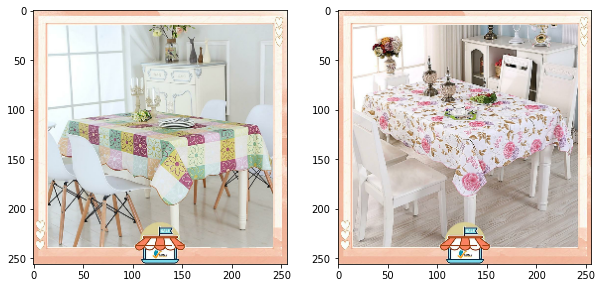

Image Embeddings:
Number of items: 1
['RSB Taplak Meja Makan Ruang Tamu Anti Air PVC Set Murah Ukuran Medium Motif']


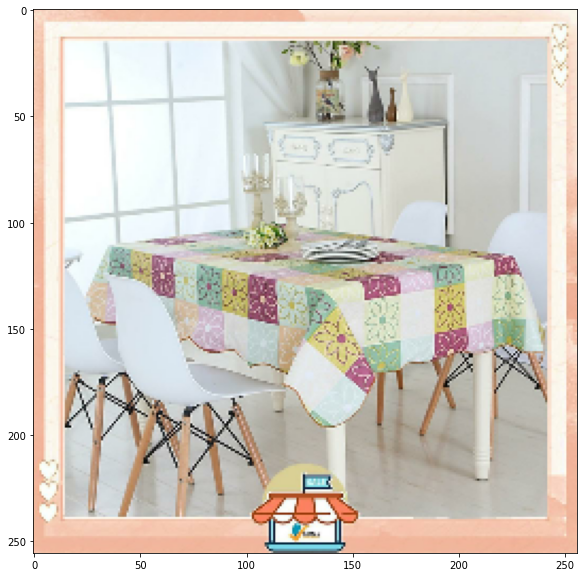

Text Embeddings:
Number of items: 2
['RSB Taplak Meja Makan Ruang Tamu Anti Air PVC Set Murah Ukuran Medium Motif'
 'RSB Taplak Meja Makan Ruang Tamu Anti Air PVC Set Murah Ukuran BESAR Motif']


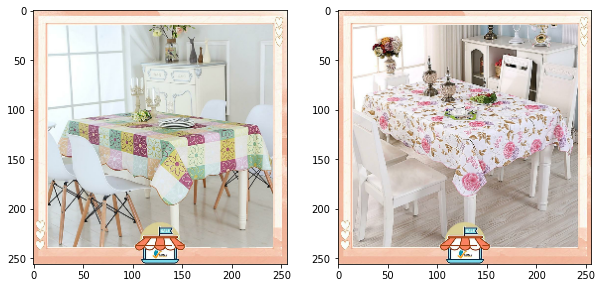

In [ ]:
df_example = df_perfect.sample(1) # index: 33119
print('Ground Truth:')
results_inspection(df_train, df_example, 'target')
print('Image Embeddings:')
results_inspection(df_train, df_example, 'image_matches')
print('Text Embeddings:')
results_inspection(df_train, df_example, 'text_matches')

Ground Truth:
Number of items: 7
['Pisau Dapur Buah Sayur Tajam / Pemotong Makanan / Kupas Buah Warna Warni'
 'BAHAN STAINLESS/ Pisau Kupas Buah Dan Sayuran / Pisau Dapur Tajam Anti Karat /Pisau Dapur Serbaguna'
 'PISAU DAPUR BUAH SAYUR TAJAM / PEMOTONG MAKANAN / KUPAS BUAH WARNA WARNI /PISAU'
 'PISAU BUAH MURAH MERIAH [ 50 -  MMI ]' 'PISAU DAPUR / PISAU KECIL MURAH'
 'PISAU BUAH STAINLESS STEEL TERMURAH !! [50]'
 'Pisau Dapur Kupas Buah Sayur Potong Tajam Stainless Steel Serbaguna Anti Karat Warna Warni']


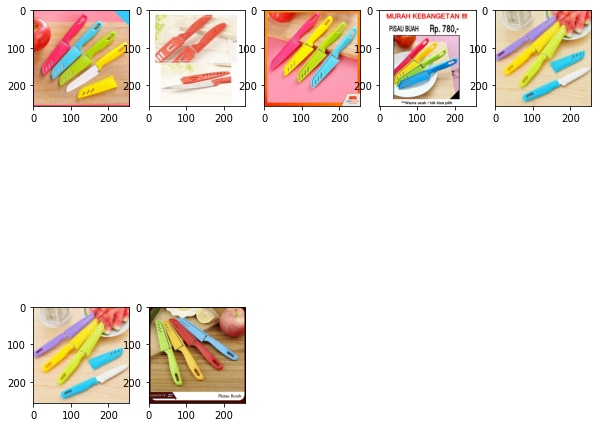

Image Embeddings:
Number of items: 1
['PISAU BUAH MURAH MERIAH [ 50 -  MMI ]']


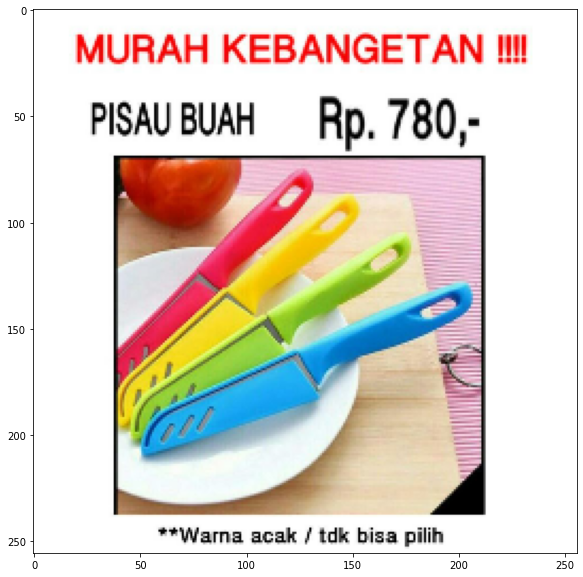

Text Embeddings:
Number of items: 1
['PISAU BUAH MURAH MERIAH [ 50 -  MMI ]']


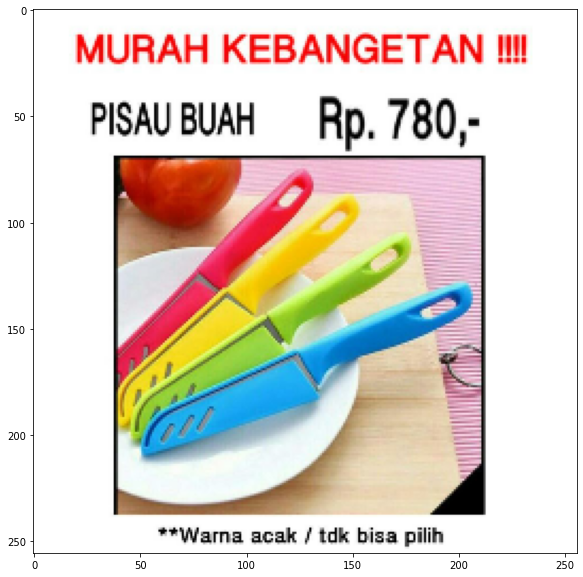

In [ ]:
df_example = df_bad.sample(1) 
print('Ground Truth:')
results_inspection(df_train, df_example, 'target')
print('Image Embeddings:')
results_inspection(df_train, df_example, 'image_matches')
print('Text Embeddings:')
results_inspection(df_train, df_example, 'text_matches')